# Проект для «Викишоп» c Bert

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. 

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.



## Импортируем библиотеки

In [ ]:
!pip install catboost
!pip install feature-engine
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Модели

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, KFold


from sklearn.metrics import f1_score, roc_auc_score, mean_squared_error, mean_absolute_error, make_scorer


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams, rcParamsDefault
from sklearn.model_selection import GridSearchCV
import numpy as np
import itertools 
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from functools import reduce   
from scipy import stats as st

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn import linear_model
from feature_engine.selection import DropCorrelatedFeatures, DropDuplicateFeatures

from imblearn.pipeline import make_pipeline
from numpy.random import RandomState
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import LabelEncoder

import re
import nltk 
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
import string 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
import sys

import torch
import transformers as ppb # pytorch transformers
from tqdm import notebook

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Изучение данных

In [ ]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [ ]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [ ]:
data.describe()

,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


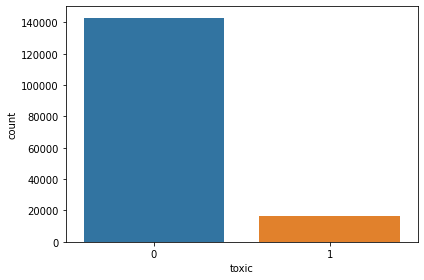

In [ ]:
sns.countplot(x = data['toxic'])
plt.tight_layout()

In [ ]:
data

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


**Вывод**
Для выполнения проекта необходимо:
- Предобработать данные
- Обучить модели

<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены корреткно. Радует, что баланс классов был изучен.
</div>

## Подготовка данных

### Удалим лишнюю колонку

In [ ]:
data = data.drop(['Unnamed: 0'], axis=1)

In [ ]:
data_bert = data.copy()
data_bert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


### Удалим пунктуацию

In [ ]:
def remove_punctuation(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

In [ ]:
data['lemm_text'] = data['text'].apply(lambda x: remove_punctuation(x))

In [ ]:
data.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation\nWhy the edits made under my usern...
1,D'aww! He matches this background colour I'm s...,0,Daww He matches this background colour Im seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man Im really not trying to edit war Its j...
3,"""\nMore\nI can't make any real suggestions on ...",0,\nMore\nI cant make any real suggestions on im...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...


### Токенизируем

In [ ]:
def tokenise(text):
    text = re.split('\W+', text)
    return text


In [ ]:
 data['lemm_text'] = data['lemm_text'].apply(lambda x: tokenise(x.lower()))

In [ ]:
data.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,"[explanation, why, the, edits, made, under, my..."
1,D'aww! He matches this background colour I'm s...,0,"[daww, he, matches, this, background, colour, ..."
2,"Hey man, I'm really not trying to edit war. It...",0,"[hey, man, im, really, not, trying, to, edit, ..."
3,"""\nMore\nI can't make any real suggestions on ...",0,"[, more, i, cant, make, any, real, suggestions..."
4,"You, sir, are my hero. Any chance you remember...",0,"[you, sir, are, my, hero, any, chance, you, re..."


### Удалим стоп слова

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')  

In [ ]:
def remove_stopwords(text):
    text = [word for word in text if word not in stopwords]
    return text

In [ ]:
data['lemm_text'] = data['lemm_text'].apply(lambda x: remove_stopwords(x))

In [ ]:
data.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,"[explanation, edits, made, username, hardcore,..."
1,D'aww! He matches this background colour I'm s...,0,"[daww, matches, background, colour, im, seemin..."
2,"Hey man, I'm really not trying to edit war. It...",0,"[hey, man, im, really, trying, edit, war, guy,..."
3,"""\nMore\nI can't make any real suggestions on ...",0,"[, cant, make, real, suggestions, improvement,..."
4,"You, sir, are my hero. Any chance you remember...",0,"[sir, hero, chance, remember, page, thats]"


### Леммизируем текст

In [ ]:
lemmatizer = nltk.WordNetLemmatizer()

In [ ]:
def lemmatise_this(text):
    text = [lemmatizer.lemmatize(word) for word in text]
    return text

In [ ]:
data['lemm_text'] = data['lemm_text'].apply(lambda x: lemmatise_this(x))

In [ ]:
data.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,"[explanation, edits, made, username, hardcore,..."
1,D'aww! He matches this background colour I'm s...,0,"[daww, match, background, colour, im, seemingl..."
2,"Hey man, I'm really not trying to edit war. It...",0,"[hey, man, im, really, trying, edit, war, guy,..."
3,"""\nMore\nI can't make any real suggestions on ...",0,"[, cant, make, real, suggestion, improvement, ..."
4,"You, sir, are my hero. Any chance you remember...",0,"[sir, hero, chance, remember, page, thats]"


### Удалим пропуски

In [ ]:
def remove_empty(text):
    text = list(filter(None, text))
    return text

data['lemm_text'] = data['lemm_text'].apply(lambda x: remove_empty(x))
data.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,"[explanation, edits, made, username, hardcore,..."
1,D'aww! He matches this background colour I'm s...,0,"[daww, match, background, colour, im, seemingl..."
2,"Hey man, I'm really not trying to edit war. It...",0,"[hey, man, im, really, trying, edit, war, guy,..."
3,"""\nMore\nI can't make any real suggestions on ...",0,"[cant, make, real, suggestion, improvement, wo..."
4,"You, sir, are my hero. Any chance you remember...",0,"[sir, hero, chance, remember, page, thats]"


In [ ]:
data.sample(10)# Случайный семпл на всякий случай.

,text,toxic,lemm_text
109591,When you delete what I write without any attem...,0,"[delete, write, without, attempt, know, wrote,..."
152916,I believe religious views should be taken into...,1,"[believe, religious, view, taken, consideratio..."
124494,Please stop. If you continue to vandalize page...,0,"[please, stop, continue, vandalize, page, quar..."
15904,Uncited works \nDon't remove good examples sim...,0,"[uncited, work, dont, remove, good, example, s..."
19707,""": Students are taught of the national animal,...",0,"[student, taught, national, animal, leaf, flag..."
118831,Cross\n\nIs that a cross or the crest?\n\nI't ...,0,"[cross, cross, crest, probably, crist, dub, re..."
109126,"""\n\nGoethean can bite me\n\nMake no mistake, ...",0,"[goethean, bite, make, mistake, absolutely, re..."
134541,""":::::It can and should be restored. Oh and le...",0,"[restored, oh, let, quote, please, note, discu..."
19793,"""\n\nAccording to http://www.breitbart.com/big...",0,"[according, httpwwwbreitbartcombiggovernmentpo..."
65044,"""\n\nWhat is Rob referring to when he says he ...",0,"[rob, referring, say, kicked, tour, surfline, ..."


#### Bert

#### Выделим часть датасета

In [ ]:
batch_1 = data[:1000]

In [ ]:
batch_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       1000 non-null   object
 1   toxic      1000 non-null   int64 
 2   lemm_text  1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


#### For DistilBERT

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 
                                                    'distilbert-base-uncased')

#### Загрузим готовую модель и токенизатор

In [ ]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
#model.config.max_position_embeddings = 2048

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Bert токенизация

In [ ]:
batch_1['text']

0      Explanation\nWhy the edits made under my usern...
1      D'aww! He matches this background colour I'm s...
2      Hey man, I'm really not trying to edit war. It...
3      "\nMore\nI can't make any real suggestions on ...
4      You, sir, are my hero. Any chance you remember...
                             ...                        
995    " Hi, Writingrights, Welcome to Wikipedia!  \n...
996    It is common knowledge that Karaims (but not K...
997    , 12 April 2006 (UTC)\nThen rewrite and expand...
998    "I was trying to inject some humour (as eviden...
999    this title should redirect to Altona, Hamburg....
Name: text, Length: 1000, dtype: object

In [ ]:
bert_tokenized = batch_1['text'].apply((lambda x: tokenizer.encode(x, padding=True, truncation=True,max_length=220, add_special_tokens = True)))

In [ ]:
#bert_tokenized = batch_1['text'].apply((lambda x: tokenizer.encode(x, padding=True, truncation=True,max_length=200, add_special_tokens = True)))

In [ ]:
bert_tokenized

0      [101, 7526, 2339, 1996, 10086, 2015, 2081, 210...
1      [101, 1040, 1005, 22091, 2860, 999, 2002, 3503...
2      [101, 4931, 2158, 1010, 1045, 1005, 1049, 2428...
3      [101, 1000, 2062, 1045, 2064, 1005, 1056, 2191...
4      [101, 2017, 1010, 2909, 1010, 2024, 2026, 5394...
                             ...                        
995    [101, 1000, 7632, 1010, 3015, 15950, 2015, 101...
996    [101, 2009, 2003, 2691, 3716, 2008, 13173, 571...
997    [101, 1010, 2260, 2258, 2294, 1006, 11396, 100...
998    [101, 1000, 1045, 2001, 2667, 2000, 1999, 2061...
999    [101, 2023, 2516, 2323, 2417, 7442, 6593, 2000...
Name: text, Length: 1000, dtype: object

#### Padding

In [ ]:
max_len = 0
for i in bert_tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in bert_tokenized.values])

In [ ]:
 np.array(padded).shape

(1000, 220)

#### Masking

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(1000, 220)

In [ ]:
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask)

#### Target and Features


In [ ]:
features = last_hidden_states[0][:,0,:].numpy()

In [ ]:
features.shape

(1000, 768)

In [ ]:
target = batch_1['toxic']

In [ ]:
target.shape

(1000,)

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=42)

In [ ]:
print('Размер обучающей выборки: {} объектов, {} признаков'.format(features_train.shape[0], features_train.shape[1]))
print('Размер тестовой выборки: {} объектов, {} признаков'.format(features_test.shape[0], features_test.shape[1]))


Размер обучающей выборки: 750 объектов, 768 признаков
Размер тестовой выборки: 250 объектов, 768 признаков


#### Logistic Regression

In [ ]:
logreg = LogisticRegression()


In [ ]:
params =  {
          'class_weight':['balanced', None],
          'C':[1,10,100, 500],
           'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
           'max_iter': [50, 100, 200, 500, 1000]
           
    }

grid_model_logreg = GridSearchCV(logreg, params, cv=5,
                          scoring='f1', n_jobs=-1)


grid_model_logreg.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 500],
                         'class_weight': ['balanced', None],
                         'max_iter': [50, 100, 200, 500, 1000],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']},
             scoring='f1')

In [ ]:
grid_model_logreg.best_score_

0.7273020796407894

#### LightGBM

In [ ]:
#light_gbm = LGBMClassifier()

In [ ]:
# params = {
#           'boosting_type': ['gbdt'],
#            'objective': ['binary'],          
#            'learning_rate': [0.5, 0.05, 0.005],
#             'num_leaves':[50,75],
             
            
            
          
#             }
# grid_model_gbm = GridSearchCV(light_gbm, params, cv=3,
#                           scoring='f1', n_jobs=-1)

# grid_model_gbm.fit(features_train, target_train)

In [ ]:
# grid_model_gbm.best_score_

### Test Set

In [ ]:
logreg_preds_test =  grid_model_logreg.best_estimator_.predict(features_test)
logreg_f1_test = f1_score(target_test, logreg_preds_test)
logreg_f1_test

0.7058823529411764

**Вывод**

Лучший показатель f1 в ходе кроссвалидации у модели LogisticRegression

## Проверка лучшей модели на тестовой выборке

**Вывод** 

Показатель f1 на тестовой выборке у лучшей модели равен 0.7627468317123489. Это соответствует требованиям

## Общий вывод

В ходе работы над проектом данные были предобработаны следующим образом:

 - Удалена пунктуация
 - Проведена токенезация
 - Удалены стоп-слова
 - Текст был леммизирован
 - Удалены пропуски

Для каждого этапа были написаны функции. Конечный результат был помещен в отдельный столбец датасета. В дальнейшем текст помещен в корпус и векторизирован.

Были обучены следующие модели:

 - LightGBM ее показатель при кроссвалидации f1 0.7636170739229847
 - LogisticRegression ее показатель при кроссвалидации f1 0.7651350162972251
 
Было решено использовать LogisticRegression. Показатель f1 на тестовой выборке у лучшей модели равен 0.7627468317123489. Это соответствует требованиям.   
 
    